- atoms object as input for fitting
- atoms object and list of triplets as input for prediction
- learning single snapshot
- sampling single snapshot (random triplets, most relevant triplets)

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.spatial as spatial

import matplotlib.pyplot as plt

from ase import atoms
from ase.io import read


In [2]:
filename = 'test/data/BIP_300/movie.xyz'
traj = read(filename, index=slice(0,5))
len(traj)

5

In [24]:
atoms = traj[0]
elements = atoms.get_array('numbers')
positions = atoms.get_positions()
forces = atoms.get_array('force')

In [21]:
def distance_matrix(atoms, r_cut, method='ckdtree', output_type=''):
    if method == 'ckdtree':
        kdtree = spatial.cKDTree(atoms.get_positions())
        d_matrix = kdtree.sparse_distance_matrix(kdtree, r_cut, output_type)
        return d_matrix

In [4]:
kdtree = spatial.cKDTree(atoms.get_positions())

In [5]:
d_matrix = kdtree.sparse_distance_matrix(kdtree, 3.)

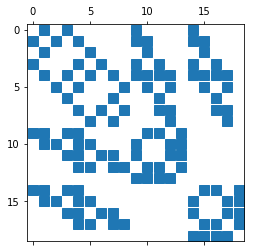

In [6]:
plt.spy(d_matrix)

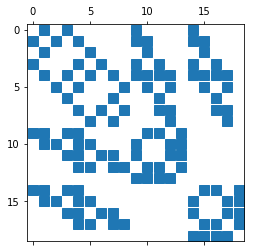

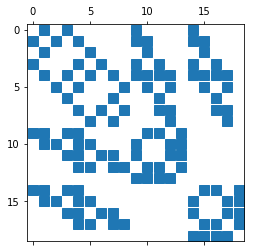

In [25]:
kdtree_1 = spatial.cKDTree(traj[0].get_positions())
kdtree_2 = spatial.cKDTree(traj[-1].get_positions())
d_matrix_1 = kdtree_1.sparse_distance_matrix(kdtree_1, 3.)
d_matrix_2 = kdtree_2.sparse_distance_matrix(kdtree_2, 3.)
plt.spy(d_matrix_1)
plt.show()
plt.spy(d_matrix_2)
plt.show()


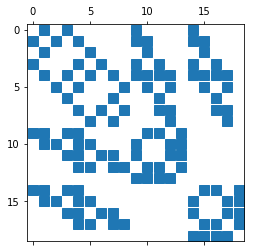

In [16]:
d_matrix_1 = kdtree_1.sparse_distance_matrix(kdtree_1, 3.)
d_matrix_2 = kdtree_2.sparse_distance_matrix(kdtree_2, 3.)
plt.spy(d_matrix_1 - d_matrix_2)
# plt.spy(d_matrix_2)
plt.show()

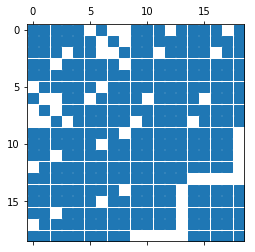

In [31]:
plt.spy(np.kron(d_matrix_1, d_matrix_2))

In [63]:
for d in d_matrix_1[1,:]:
    print(d)

  (0, 0)	2.34151647395
  (0, 2)	2.34179797036
  (0, 4)	2.42659247996
  (0, 9)	2.41613895947
  (0, 10)	2.41593176683
  (0, 14)	2.43144445654
  (0, 15)	2.43244505633


In [55]:
sp.kronsum(d_matrix_1, -d_matrix_1)

<361x361 sparse matrix of type '<class 'numpy.float64'>'
	with 4560 stored elements in Compressed Sparse Row format>

In [57]:
sigma = 1.

x = sp.kronsum(d_matrix_1, -d_matrix_1)
np.exp(x.data, out=x.data )
x

<361x361 sparse matrix of type '<class 'numpy.float64'>'
	with 4560 stored elements in Compressed Sparse Row format>

In [60]:
x.elemwise

AttributeError: elemwise not found

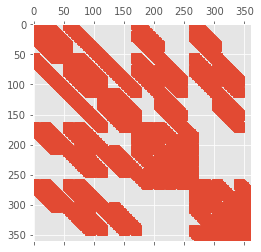

In [58]:
plt.spy(x)

# Gpflow

In [43]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
%matplotlib inline

In [44]:
import gpflow
import tensorflow as tf

class Brownian(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(input_dim=1, active_dims=[0])
        self.variance = gpflow.Param(1.0, transform=gpflow.transforms.positive)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return self.variance * tf.minimum(X, tf.transpose(X2))

    def Kdiag(self, X):
        return self.variance * tf.reshape(X, (-1,))


/usr/local/miniconda3/envs/dev/lib/python3.6/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.218895
  Number of iterations: 23
  Number of functions evaluations: 27


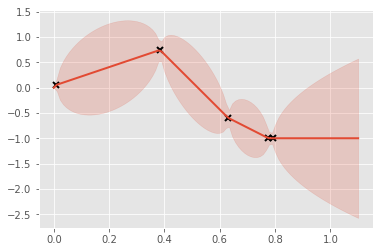

In [45]:
X = np.random.rand(5, 1)
Y = np.sin(X*6) + np.random.randn(*X.shape)*0.001


k1 = Brownian()
k2 = gpflow.kernels.Constant(1)
k = k1 + k2

m = gpflow.models.GPR(X, Y, kern=k)
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

xx = np.linspace(0, 1.1, 100).reshape(100, 1)
mean, var = m.predict_y(xx)
plt.plot(X, Y, 'kx', mew=2)
line, = plt.plot(xx, mean, lw=2)
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)

In [48]:
k.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/brownian/variance,Parameter,None,+ve,True,(),True,1.995006697774781
GPR/kern/constant/variance,Parameter,None,+ve,True,(),True,1.0083605932938102e-06


In [65]:
import numpy as np
from scipy.sparse import dok_matrix
S = dok_matrix((5, 5), dtype=np.float32)
for i in range(5):
    for j in range(5):
        S[i,j] = i+j    # Update element

In [66]:
S

<5x5 sparse matrix of type '<class 'numpy.float32'>'
	with 24 stored elements in Dictionary Of Keys format>

In [69]:
np.exp2(S)

AttributeError: exp2 not found

In [102]:
np.random.seed(0)

sigma = 1.

r1 = np.random.normal(size=(1,3))
r2 = np.random.normal(size=(1,3))

d1, d2 = np.linalg.norm(r1), np.linalg.norm(r2)
r1_hat, r2_hat = r1/d1, r2/d2


K1 = 1/sigma**2 * np.exp(-np.linalg.norm(r1-r2)**2/(2*sigma**2)) * (np.eye(3) - 1/sigma**2 *(r1-r2)*(r1-r2).T )
K2 = 1 / sigma**2 * np.exp(-(d1 - d2) ** 2 / (2 * sigma ** 2)) * (1 - (d1 - d2) ** 2 / sigma ** 2) * r1_hat*r2_hat.T

K1, K2


(array([[ 0.03469067, -0.03141719,  0.04187849],
        [-0.03141719, -0.05178146,  0.12887429],
        [ 0.04187849,  0.12887429, -0.12688697]]),
 array([[-0.01482021, -0.00336181, -0.00822261],
        [-0.01235115, -0.00280173, -0.00685271],
        [ 0.00646326,  0.00146612,  0.00358597]]))

In [124]:

sigma = 1.

r0 = np.array([0,0,0]).reshape(1,-1)


np.random.seed(0)
r1 = np.random.normal(size=(1,3))
r2 = np.random.normal(size=(1,3))

r1  = np.array([1,0,0]).reshape(1,-1)
r2  = np.array([0,1,0]).reshape(1,-1)

d1, d2 = np.linalg.norm(r1), np.linalg.norm(r2)
r1_hat, r2_hat = r1/d1, r2/d2


def kernel1(r1, r2):
    return 1 / sigma**2 * np.exp(-np.linalg.norm(r1 - r2)**2 / (2 * sigma**2)) * \
           (np.eye(3) - 1/sigma**2 *(r1 - r2)*(r1 - r2).T )


def kernel2(r1, r2):
    d1, d2 = np.linalg.norm(r1), np.linalg.norm(r2)
    r1_hat, r2_hat = r1/d1, r2/d2
    
    return 1 / sigma**2 * np.exp(-(d1 - d2) ** 2 / (2 * sigma ** 2)) * (1 - (d1 - d2) ** 2 / sigma ** 2) * \
           r1_hat*r2_hat.T


K1, K2 = kernel1(r1,r0), kernel2(r2, r2)
print(K1)
print(K2)


[[ 0.          0.          0.        ]
 [ 0.          0.60653066  0.        ]
 [ 0.          0.          0.60653066]]
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
